In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the mode shapes and natural frequencies from Abaqus and calculating the modal system matrices
file_path = "./Data/Initial model/Deformation/grenland_bridge"

# Bridge length vector
x = np.arange(0, 609, 8)

# Mode shape matrix: 3 x n_modes x len(x)
phi = np.load(file_path + "_modes.npy")
phi = phi[:,:,::8]
phi = phi[:,:20,:]
# phi[0,:,:] = 0
# phi[2,:,:] = 0

# Frequency vector: n_modes x 1
f_n = np.load(file_path + "_frequencies.npy")
w_n = f_n * 2 * np.pi

# Damping 
xi = 0.5 / 100

# Number of modes
n_modes = phi.shape[1]

# Generalized mass matrix
M_gen = np.load(file_path + "_mass.npy") 
M_gen = M_gen[:20]

# Establishing the system matrices
M_modal = np.diag(M_gen)
K_modal = np.zeros((n_modes, n_modes))
C_modal = np.zeros((n_modes, n_modes))

# Calculating the system matrices
for i in range(n_modes):

    K_modal[i, i] = w_n[i]**2 * M_modal[i, i]

    C_modal[i, i] = 2 * M_modal[i, i] * w_n[i] * xi

In [3]:
# Calculating the wind load properties
# NS-EN 1991-1-4

# Mean wind velocity
V_b0 = 23
C_alt = max(1 + (30 - 23)* (55.233 - 900) / (23*(1500-900)) , 1)
C_dir = 1 
C_seas = 1
p = 0.5
C_prob = ((1 - 0.2 * np.log(-np.log(1-p))) / (1 - 0.2 * np.log(-np.log(0.98)))) **0.5
C_0 = 1 
z0 = 0.001
z1 = 10
zmin = 2
L1 = 100
z = 55.233
kr = 0.17
C_r = kr * np.log(z / z0)

V = V_b0 * C_dir* C_seas * C_alt * C_prob * C_0 * C_r

# Wind spectra properties
rho = 1.25
Au = 6.8 
Av = 9.4 
Aw = 9.4 
xLu = L1 * (z / z1)**0.3
xLv = 1 / 4 * xLu
xLw = 1 / 12 * xLu
k_i = 1
Iu = kr * V_b0 * k_i / V
Iv = 3 / 4 * Iu
Iw = 1 / 2 * Iu

# Bridge deck properties
D = 2.6
B = 12
CD_prime = 0
CD_bar = 1.0
CL_prime = 2.22
CL_bar = -0.58
CM_prime = 0.786
CM_bar = -0.017
C_u = 9
C_w = 6 

In [4]:
# Calculating the cross-spectral density of the wind load 

# Buffeting wind load matrices
B_q = np.array([
    [2 * (D / B)* CD_bar, ((D / B) * CD_prime - CL_bar)],
    [2 * CL_bar, (CL_prime + (D / B) * CD_bar)],
    [2 * B * CM_bar, B * CM_prime]
])

C_ae = - rho * V * B / 2 * np.array([
    [2 * (D / B)* CD_bar, ((D / B) * CD_prime - CL_bar), 0],
    [2 * CL_bar, (CL_prime + (D / B) * CD_bar), 0],
    [2 * B * CM_bar, B * CM_prime, 0]
])

K_ae = rho * V**2 * B / 2 * np.array([
    [0, 0, (D / B) * CD_prime],
    [0, 0, CL_prime],
    [0, 0, B * CM_prime]
])

# Frequency vector
w = np.logspace(-3, 1.2, 100)
f = w / (2 * np.pi)

# Wind turbulence 
Su = (Iu*V)**2*Au*xLu/V / ((1+1.5*Au*f*xLu/V)**(5/3)) / (2 * np.pi)
Sw = (Iw*V)**2*Aw*xLw/V / ((1+1.5*Aw*f*xLw/V)**(5/3)) / (2 * np.pi)

# Extending B_q and phi for matrix multiplication
B_q_extended = np.zeros((len(x) * 3, len(x) * 2))

for i in range(len(x)):
    B_q_extended[i*3:(i*3)+3, i*2:(i*2)+2] = B_q

phi_extended = np.zeros((3 * len(x), len(x), n_modes))

for i in range(n_modes):
    for j in range(len(x)):

        phi_extended[j*3:(j*3)+3, j, i] = phi[:, i, j]

In [5]:
# Establishing the spectral density matrices
S_Q = np.zeros((n_modes, n_modes, len(w)), dtype=float)
S_v = np.zeros((len(x) * 2, len(x) * 2))


# Establishing dxdx meshgrid and the integrand matrix
dxdx = np.abs(np.array([x]) - np.array([x]).T)
integrand = np.zeros((len(x), len(x)))

I = np.array([[Iu, 0], [0, Iw]])

for h in range(len(w)):
    
    # One-point spectra for the wind load
    S_v[0::2, 0::2] = Su[h] * np.exp(-C_u * f[h] * dxdx / V)
    S_v[1::2, 1::2] = Sw[h] * np.exp(-C_w * f[h] * dxdx / V)
    
    S_qq = (rho * V * B / 2)**2 * B_q_extended @ S_v @ B_q_extended.T 
    
    for i in range(n_modes):
        for j in range(n_modes):
            
            integrand = phi_extended[:,:,i].T @ S_qq @ phi_extended[:,:,j]

            # S_qq = (rho * V * B / 2)**2 * B_q @ S_v[2*i:(2*i)+2,] @ B_q.T
            
            S_Q[i, j, h] = np.trapz(np.trapz(integrand, x), x)

In [6]:
# First draft for calculating the cross-spectral density of the wind load
# Does the same as the code above, but slower

# integrand = np.zeros((len(x), len(x)))


# S_v = np.zeros((2, 2))
# S_Q = np.zeros((n_modes, n_modes, len(w)), dtype=float)

# for h in range(len(w)):
#     for i in range(n_modes):
#         for j in range(n_modes):
#             for k in range(len(x)):
#                 for l in range(len(x)):

#                     # One-point spectra for the wind load
#                     S_v[0, 0] = Su[h] * np.exp(-C_u * f[h] * np.abs(x[l] - x[k]) / V)
#                     S_v[1, 1] = Sw[h] * np.exp(-C_w * f[h] * np.abs(x[l] - x[k]) / V)
#                     # print(k, l)
#                     # print(S_v)

                    
#                     S_qq = (rho * V * B / 2)**2 * B_q @ S_v @ B_q.T # 3 x 3

#                     # print(B_q @ S_v @ B_q.T)
#                     # print(S_qq)

#                     integrand[k, l] = phi[:, i, k].T @ S_qq @ phi[:, j, l] # 1 x 1
                   
                    

 

#             # print(integrand[1,1,])
#         # break
#     # break
                

#             S_Q[i, j, h] = np.trapz(np.trapz(integrand, x), x) # 1 x 1

In [7]:
# Saving the cross-spectral density of the wind load

# np.save("./Results/Initial model/S_Q_initial.npy", S_Q)
# np.save("./Results/Updated model/S_Q_updated.npy", S_Q)

# Import the cross-spectral density to skip calculation

# S_Q = np.load("./Results/Initial model/S_Q_initial.npy")
# S_Q = np.load("./Results/Updated model/S_Q_updated.npy")

In [8]:
# Interpolating the cross-spectral density matrix to get better resolution in the response spectrum

w_interp = np.linspace(0.001, 15, 1000)
S_Q_interp = np.zeros((n_modes, n_modes, len(w_interp)))

for i in range(n_modes):
    for j in range(n_modes):

        S_Q_interp[i, j, :] = np.interp(w_interp, w, S_Q[i, j, :])

In [9]:
# Calculating the frequency response function

C_ae_modal = np.zeros((n_modes, n_modes))
K_ae_modal = np.zeros((n_modes, n_modes))
H_modal = np.zeros((n_modes, n_modes, len(w_interp)), dtype=complex)

C_integrand = np.zeros(len(x))
K_integrand = np.zeros(len(x))

for i in range(n_modes):
    for j in range(n_modes):
        for k in range(len(x)):
            C_integrand[k] = phi[:,i,k].T @ C_ae @ phi[:,j,k]
            K_integrand[k] = phi[:,i,k].T @ K_ae @ phi[:,j,k]

        C_ae_modal[i, j] = np.trapz(C_integrand, x)
        K_ae_modal[i, j] = np.trapz(K_integrand, x)



for i in range(len(w_interp)):
    H_modal[:,:,i] = np.linalg.inv((-w_interp[i]**2 * M_modal + 1j * w_interp[i] * (C_modal - C_ae_modal) + K_modal - K_ae_modal))

In [10]:
# Calculating the cross-spectral density of the response based on the DEFORMATION
# phi_r = phi

phi_r = np.zeros((3 * len(x), n_modes))

for i in range(n_modes):
    for j in range(len(x)):
        phi_r[j*3:(j*3)+3, i] = phi[:, i, j]

# Cross-spectral density of the response
S_rr = np.zeros((3 * len(x), 3 * len(x), len(w_interp)), dtype=complex)

for i in range(len(w_interp)):
    S_rr[:,:,i] = phi_r @ (np.conj(H_modal[:,:,i]) @ S_Q_interp[:,:,i] @ H_modal[:,:,i].T) @ phi_r.T

In [11]:
# Calculating the maximum deformation from the standard deviation

std_dev_y = np.zeros((len(x)), dtype=complex)
std_dev_z = np.zeros((len(x)), dtype=complex)
std_dev_t = np.zeros((len(x)), dtype=complex)

for i in range(len(x)):
    std_dev_y[i] = np.trapz(S_rr[3*i, 3*i, :], w_interp)**0.5
    std_dev_z[i] = np.trapz(S_rr[3*i+1, 3*i+1, :], w_interp)**0.5
    std_dev_t[i] = np.trapz(S_rr[3*i+2, 3*i+2, :], w_interp)**0.5

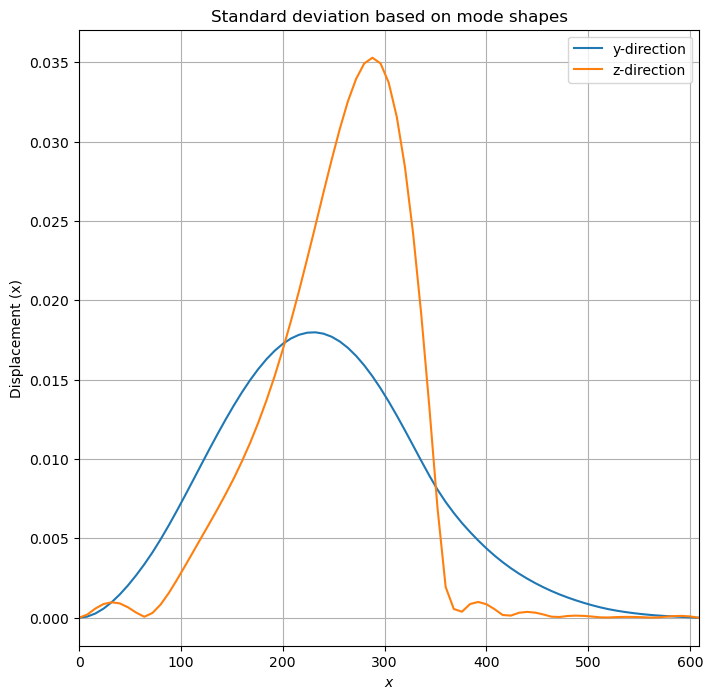

In [12]:
plt.figure(figsize=(8,8))
plt.plot(x, std_dev_y.real, label="y-direction")
plt.plot(x, std_dev_z.real, label="z-direction")
plt.legend()
plt.xlim(0, 609)
# plt.ylim(0, 7)
plt.grid()
plt.title("Standard deviation based on mode shapes")
plt.xlabel("$x$")
plt.ylabel("Displacement (x)")
plt.show()

In [13]:
# Calculating the cross-spectral density of the response based on the MOMENT
# phi_r = phi_moment

# Importing mode shapes based on moment
phi_moment = np.load("./Data/Initial model/Moment/grenland_bridge_modes.npy")
phi_moment = phi_moment[:,:,::8]
phi_moment = phi_moment[:,:20,:]

phi_r_moment = np.zeros((3 * len(x), n_modes))

for i in range(n_modes):
    for j in range(len(x)):
        phi_r_moment[j*3:(j*3)+3, i] = phi_moment[:, i, j]

# Cross-spectral density of the response
S_rr_moment = np.zeros((3 * len(x), 3 * len(x), len(w_interp)), dtype=complex)

for i in range(len(w_interp)):
    S_rr_moment[:,:,i] = phi_r_moment @ (np.conj(H_modal[:,:,i]) @ S_Q_interp[:,:,i] @ H_modal[:,:,i].T) @ phi_r_moment.T

In [14]:
# Calculating the maximum moment from the standard deviation

std_dev_y_moment = np.zeros((len(x)), dtype=complex)
std_dev_z_moment = np.zeros((len(x)), dtype=complex)
std_dev_t_moment = np.zeros((len(x)), dtype=complex)

for i in range(len(x)):
    std_dev_y_moment[i] = np.trapz(S_rr_moment[3*i, 3*i, :], w_interp)**0.5 
    std_dev_z_moment[i] = np.trapz(S_rr_moment[3*i+1, 3*i+1, :], w_interp)**0.5
    std_dev_t_moment[i] = np.trapz(S_rr_moment[3*i+2, 3*i+2, :], w_interp)**0.5

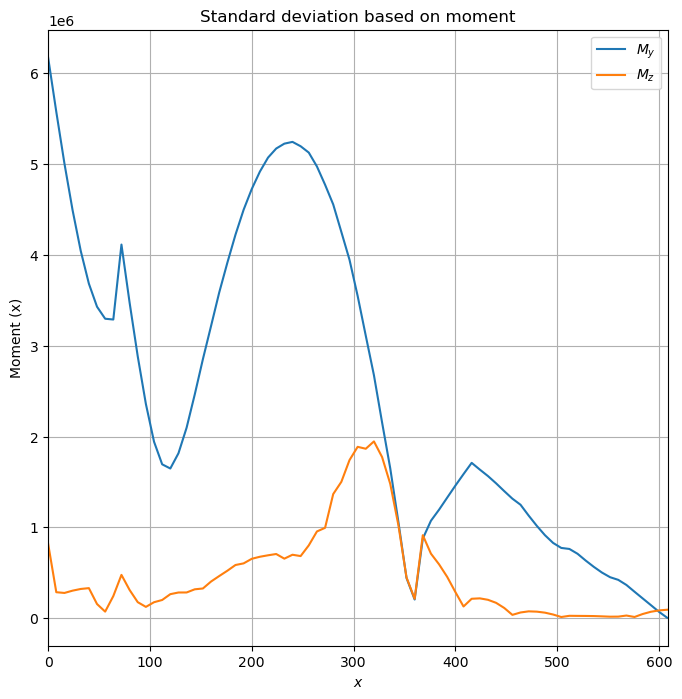

In [15]:
plt.figure(figsize=(8,8))
plt.plot(x, std_dev_y_moment.real, label="$M_y$")
plt.plot(x, std_dev_z_moment.real, label="$M_z$")
plt.legend()
plt.xlim(0, 609)
# plt.ylim(0, 240)
plt.grid()
plt.title("Standard deviation based on moment")
plt.xlabel("$x$")
plt.ylabel("Moment (x)")
plt.show()

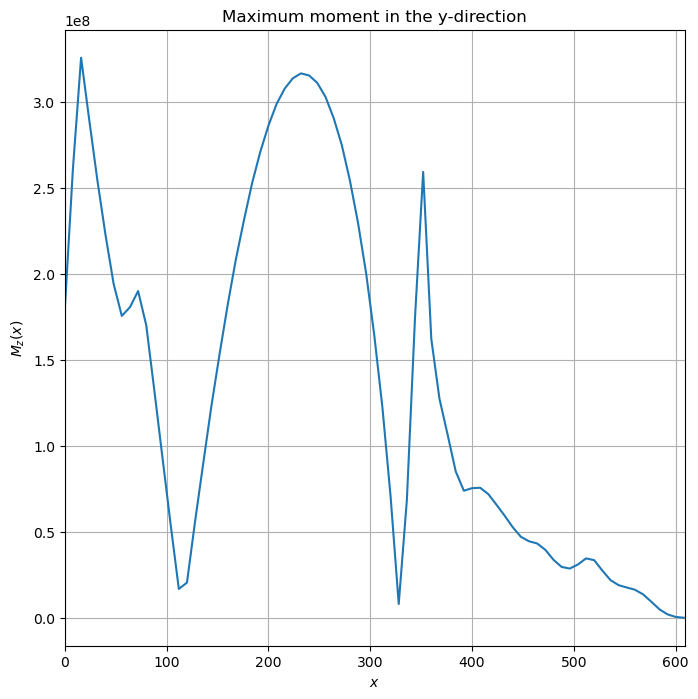

In [16]:
# Calculating bending moment based on the deformation using formula
# M = EI * y''
# Test: Not producing the correct answer atm

EI1 = 2.92893E+12
EI2 = 1.93233E+12

EI = np.zeros_like(std_dev_y.real)
EI[:45] = EI1
EI[45:] = EI2

dydy = np.gradient(np.gradient(std_dev_y.real))

M = EI * dydy

plt.figure(figsize=(8,8))
plt.grid()
# Plotting the absolute value of the moment gave a plot similar to the plot above
plt.plot(x, np.abs(M))
plt.xlim(0, 609)
plt.title("Maximum moment in the y-direction")
plt.xlabel("$x$")
plt.ylabel("$M_z(x)$")
plt.show()